# Red neuronal desde 0

## Imports

In [2]:
import numpy as np
#Serelizar y deserializar objetos Python
import pickle
#Dataset 
from sklearn.datasets import fetch_openml
#Paths
import os.path

## Definición de Framework

### Funciones

In [3]:
"""
Definición de funciones de activación, derivadas 
"""
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_grad(sigmoid):
    """
    NOTA: Observe que recibe el sigmoid ya calculado
    """
    return sigmoid * (1.0 - sigmoid)

def relu(x):
    return x * (x > 0)

def relu_grad(x):
    return 1.0 * (x > 0)

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def logloss (x, y):
    probs = softmax(x)
    return probs, y * np.log(probs)* -1

def batch_hits(x, y):
    """ Aciertos """
    return np.sum(np.argmax(x, axis=1) == y)

### Base

In [4]:
class base():
    """ Codigo de clase base para crear una capa
        Cada capa debe de implementar su método de forward y backward
        Además debe de almacenar el calculo de self.grads
    """
    def __init__(self, input_size, output_size, use_xavier = True) -> None:
        self.input_size = input_size
        self.output_size = output_size
        if use_xavier:
            self._xavier_initialization() 
        else:
            self._initialization_uniform()
        self.o = np.zeros(output_size)
        self.x = None # Asignado durante el forward

    def _initialization_uniform(self):
        self.W = np.random.randn(self.input_size, self.output_size)
        self.b = np.random.randn(self.output_size)
        
    def _xavier_initialization(self):
        """
        Understanding the difficulty of training deep feedforward neural networks
        Xavier Glorot, Yoshua Bengio
        """
        self.W = np.random.randn(self.input_size, self.output_size) / np.sqrt(self.input_size)
        self.b = np.random.randn(self.output_size)
    
    def forward(self, x):
        pass
    
    def backward(self, prev):
        pass

    def update(self, lr):
        self.W += lr * np.dot(self.x.T, self.grads)#
        self.b += lr * np.mean(self.grads, axis = 0)


### Loss Layer

In [5]:
class loss_layer(base):
    """
    Capa de perdida:
    Implementa la clase base, utiliza la función de perdida softmax 
    """
    def __init__(self, input_size, output_size) -> None:
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))

    def forward(self, x):
        self.x = x
        linear = np.dot(x, self.W) + self.b
        self.output = softmax(linear)
        return self.output
    
    def backward(self, y):
        #Transformación a one hot vector
        one_hot = self._transform_into_one_hot(self.output, y)
        #Calculo de gradientes
        self.grads = one_hot - self.output

    def _transform_into_one_hot(self, probs, y):
        one_hot = np.zeros(probs.shape)
        one_hot[np.arange(probs.shape[0]), y] = 1
        return one_hot
    
    def loss(self, y):
        one_hot = self._transform_into_one_hot(self.output, y)
        return -np.mean(np.sum(one_hot * np.log(self.output + 1e-15), axis=1))
        

### Dense Layer

In [6]:
class dense(base):
    """
    Dense o FullyConnected 
    Recibe tamaños de entrada y salida, mas la funcion de activacion y su derivada.
    """
    def __init__(self, input_size, output_size, func_acivation, func_acivation_grad):
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))
        self.func_activation = func_acivation
        self.func_acivation_grad = func_acivation_grad
        
    def forward(self, x):
        self.x = x
        self.linear = np.dot(x, self.W) + self.b
        self.o = self.func_activation(self.linear)
        return self.o 

    def backward(self, prev):
        # al-2 < al-1 < al.x  
        # al = prev = sigmoid(x)
        self.grads = self.func_acivation_grad(prev.x) * np.dot(prev.grads, prev.W.T)

## Definición de Modelo

In [7]:
class model():
    """
    Representa todo el modelo, el tamaño de entrada  y salida de la red,
    una lista con el tamaño que debe llevar cada capa oculpa, y las funciones de activación
    y gradiente que van a tener todas las capas ocultas
    NOTA: Todas las capas ocultas tienen la misma funcion. 
    """
    def __init__(self, input_size, output_size, hidden_shapes, func_acti, func_acti_grad):
        assert(len(hidden_shapes) > 0), "Debe tener al menos 1 capa oculta"
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.hidden_amount = len(self.hidden_shapes)
        self.hidden_layers = [] #Bucket de capas ocultas
        self._populate_layers(func_acti, func_acti_grad)

    def _populate_layers(self, func_acti, func_acti_grad):
        """
        Crea todas las capas ocultas de acuerdo al input size y hidden_shapes
        Agrega una capa final de perdida
        """
        input_size = self.input_size
        for i in range(0, self.hidden_amount):
            new_dense_layer = dense(input_size, self.hidden_shapes[i], func_acti, func_acti_grad)
            self.hidden_layers.append(new_dense_layer)
            input_size = self.hidden_shapes[i]

        self.loss_layer = loss_layer(input_size, self.output_size)

    def forward(self,x, y):
        """ Propaga las entradas a traves de la red 
        Returna las probabilidades y la perdida"""
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        self.o = self.loss_layer.forward(data)
        loss = self.loss_layer.loss(y)
        
        return self.o, loss
    
    def predict(self, x):
        """ Propaga las entradas a traves de la red 
        Returna las probabilidades"""
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        return self.loss_layer.forward(data)
    
    def backward(self, y, o):
        #Calcula la gradiente de la perdida con respecto a la etiqueta Y
        self.loss_layer.backward(y)
        prev = self.loss_layer

        for i in reversed(range(self.hidden_amount)):
            #Propaga la capa para el calculo de gradientes en cada una
            self.hidden_layers[i].backward(prev)
            prev = self.hidden_layers[i]

    def update(self, lr):
        """ Ejecuta la actualización de parametros para cada capa
            despues de actualizar los gradientes
        """
        for i in range(self.hidden_amount):
            self.hidden_layers[i].update(lr)
        self.loss_layer.update(lr)

## Dataset

In [8]:
""" Descarga el dataset de sklearns """
from sklearn.datasets import fetch_openml
filename = 'nmist.ds'
if not os.path.exists(filename):
    mnist = fetch_openml('mnist_784')
    outfile = open(filename,'wb')
    pickle.dump(mnist, outfile)
    outfile.close()



In [9]:
def _shuffle(x, y):
    assert(len(x) == len(y)), "Make sure data and labels have the same lenght!"
    rand_indexes = np.random.permutation(len(x))
    return x[rand_indexes], y[rand_indexes]

#represents a dataset, useful for val dataset, train dataset and test dataset.
class dataset():
    def __init__(self, x, y, batch_size):
        #assert(len(y) % batch_size == 0), "Make sure batch size divides number of items perfectly!"
        self.compl_x = x[:]
        self.compl_y = y[:]
        self.batch_size = batch_size
        self.reset()
        self.size = len(self.compl_y)

    def shapes(self):
        return ( self.compl_x.shape, self.compl_y.shape )

    def view(self):
        print(self.compl_x, self.compl_y)

    #iterate over the dataset
    def next(self):
        if self.left_items < self.batch_size:
            x = self.x[self.current:]
            y = self.y[self.current:]
            self.current += len(self.x)
            self.left_items = 0
            return x, y
        else:
            x = self.x[self.current:self.current+self.batch_size]
            y = self.y[self.current:self.current+self.batch_size]
            self.current += self.batch_size
            self.left_items -= self.batch_size
            return x, y

    def iter_done(self):
        return self.left_items == 0

    def reset(self):
        self.x = self.compl_x[:]
        self.y = self.compl_y[:]
        self.x, self.y = _shuffle(self.x, self.y)
        self.current = 0
        self.left_items = len(self.compl_y)

#splits a complete dataset into 3 subsets for train, val and test, by percentage
class dataset_splitter():
    def __init__(self, x, y, batch_size, perc_train=0.8, perc_val=0.2):
        self.x = x
        self.y = y
        self.split(batch_size, perc_train, perc_val)

    def _split_by_limits(self, batch_size, train_limit, val_limit):
        #Crea los dataset de entrenamiento, validación y testing
        self.ds_train = dataset(self.x[:train_limit], self.y[:train_limit], batch_size)
        self.ds_train.reset()
        self.ds_val = dataset(self.x[train_limit:val_limit], self.y[train_limit:val_limit], batch_size)
        self.ds_val.reset()
        self.ds_test = dataset(self.x[val_limit:], self.y[val_limit:], batch_size)
        self.ds_test.reset()

    def split(self, batch_size, perc_train, perc_val):
        self.x, self.y = _shuffle(self.x, self.y)
        n = len(self.x)
        train_limit = int(n * perc_train)
        temp = int(train_limit * (1.0 - perc_val))
        val_limit = train_limit - temp
        train_limit = temp
        #print(n, train_limit, val_limit)
        self._split_by_limits(batch_size, train_limit, train_limit+val_limit)
        print(self.ds_train.shapes(), self.ds_val.shapes(), self.ds_test.shapes())
        return self.ds_train, self.ds_val, self.ds_test

## Hyperparameters

In [50]:
#hyperparameters
dataset_path = r"nmist.ds"
# Se cambió el batch size para mejorar la gráfica
batch_size = 128
validate_every_no_of_batches = 400
epochs = 30
input_size = 784
output_size = 10
hidden_shapes = [ 512, 32]
# Se cambió el learning rate para mejorar la gráfica
lr = 0.001
# Learning rate de 0.0001 da validation y training más cercanos, pero peor en temas de accuracy.
output_log = r"nmist_log.txt"
with open(dataset_path, "rb") as input_file:
    #Carga el MNIST desde archivo
    nmist = pickle.load(input_file)
    x = np.array(nmist.data)
    x = x / 255.0 # Normalizacion
    y = np.array(nmist.target).astype(int)
    #print(x)
data = dataset(x, y, batch_size)
splitter = dataset_splitter(data.compl_x, data.compl_y, batch_size, 0.8, 0.2)
#Obtiene los dataset del splitter
ds_train = splitter.ds_train
ds_val = splitter.ds_val
ds_test = splitter.ds_test


((44800, 784), (44800,)) ((11200, 784), (11200,)) ((14000, 784), (14000,))


In [12]:
class ConfigEnum:
    MNIST = range(1)

#factory-like class which produces different configs for each dataset tested
class hyperparams():

    def __init__(self, config_enum=1): #default is iris based on reqs
        
    
        self.batch_size = batch_size
        self.validate_every_no_of_batches = validate_every_no_of_batches
        self.epochs = epochs
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.lr = lr
        self.output_log = output_log
        self.ds_train = ds_train
        self.ds_test = ds_test
        self.ds_val = ds_val

    def split_again(self, perc_train, perc_val):
        self.ds_train, self.ds_val, self.ds_test = self.splitter.split(self.batch_size, perc_train, perc_val)


## Ejecución

In [13]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import csv
import numpy as np


class nnlogger():
    def __init__(self, output_file, header):
        self.csv_file = open(output_file, "w")
        self.writer = csv.writer(self.csv_file, delimiter=',')
        self.writer.writerow( header )

    def write(self, line):
        self.writer.writerow( line )

    def close(self):
        self.csv_file.close()

class historian():

    def __init__(self, figsize=(8,6)):
        self.iter = []
        self.acc =  []
        self.loss = []

    def add(self, iter, loss, accuracy):
        self.iter += [ iter ]
        self.acc +=  [ accuracy ]
        self.loss += [ loss ]


class nnplotter():

    @classmethod
    def view(cls, val_history, train_history):
        ax = plt.subplot(2, 1, 1)
        ax.plot(val_history.iter, val_history.loss, 'b--', label="val")
        ax.plot(train_history.iter, train_history.loss, 'r--', label="train")
        plt.ylabel("loss")
        ax.legend()

        ax2 = plt.subplot(2, 1, 2)
        ax2.plot(val_history.iter, val_history.acc, 'b--', label="val")
        ax2.plot(train_history.iter, train_history.acc, 'r--', label= "train")
        plt.ylabel("accuracy")
        plt.xlabel("iteration")
        ax2.legend()

        plt.show()

In [ ]:
def train(nn, hp, val_hist, train_hist, logger):
    cur_epoch = 1
    cur_iter = 1
    for i in range(1, hp.epochs+1):
        train_loss = 0
        hits = 0
        cur_trained = 0
        while not(hp.ds_train.iter_done()):
            x, y = hp.ds_train.next()
            #print(y)
            o, batch_loss = nn.forward(x, y)
            nn.backward(y,o)
            nn.update(hp.lr)

            hits += batch_hits(o, y)
            cur_trained += len(x)
            train_loss += np.mean(batch_loss)

            if cur_iter % hp.validate_every_no_of_batches == 0:
                train_accuracy = float(hits) / float(cur_trained)
                train_loss = float(train_loss) / float(cur_trained)
                train_hist.add(cur_iter, train_loss, train_accuracy)
                logger.write( (cur_epoch, "Training", cur_iter, train_accuracy, train_loss) )
                hits = 0
                train_loss = 0

                val_accuracy, val_loss = test(nn, hp.ds_val, True)
                val_hist.add(cur_iter, val_loss, val_accuracy)
                logger.write( (cur_epoch, "Val", cur_iter, val_accuracy, val_loss) )
            cur_iter+=1
        cur_epoch+=1
        hp.ds_train.reset()
    return val_hist

def test(nn, ds, verbose=False, phase="Validation"):
    ds.reset()
    hits = 0
    mean_loss = 0
    while not(ds.iter_done()):
        x, y = ds.next()
        o, batch_loss = nn.forward(x, y)
        hits += batch_hits(o, y)
        mean_loss += np.mean(batch_loss)
        #if verbose:
        #    print("Loss: " + str(mean_loss), " Predicted: " + str(o), " Expected: " + str(y))
    accuracy = float(hits) / float(ds.size)
    mean_loss = float(mean_loss) / float(ds.size)
    if verbose:
        print(phase + " Accuracy: " + str(accuracy) + " Mean Loss " + str(mean_loss))
    return accuracy, mean_loss

Validation Accuracy: 0.8949107142857143 Mean Loss 0.0027965580539617138
Validation Accuracy: 0.9314285714285714 Mean Loss 0.0018800967311898354
Validation Accuracy: 0.9472321428571429 Mean Loss 0.0013907487499739105
Validation Accuracy: 0.9555357142857143 Mean Loss 0.001198507714338958
Validation Accuracy: 0.9604464285714286 Mean Loss 0.0010115985465154727
Validation Accuracy: 0.9608035714285714 Mean Loss 0.0009870131211637356
Validation Accuracy: 0.966875 Mean Loss 0.0008367298214558427
Validation Accuracy: 0.9680357142857143 Mean Loss 0.0008095330983481014
Validation Accuracy: 0.9680357142857143 Mean Loss 0.0007886310746860809
Validation Accuracy: 0.9695535714285715 Mean Loss 0.0007615960453342654
Validation Accuracy: 0.9713392857142857 Mean Loss 0.0007269151525163152
Validation Accuracy: 0.9708928571428571 Mean Loss 0.0007475834078703608
Validation Accuracy: 0.971875 Mean Loss 0.0007560536883785424
Validation Accuracy: 0.9725 Mean Loss 0.0007059762303960142
Validation Accuracy: 0.97

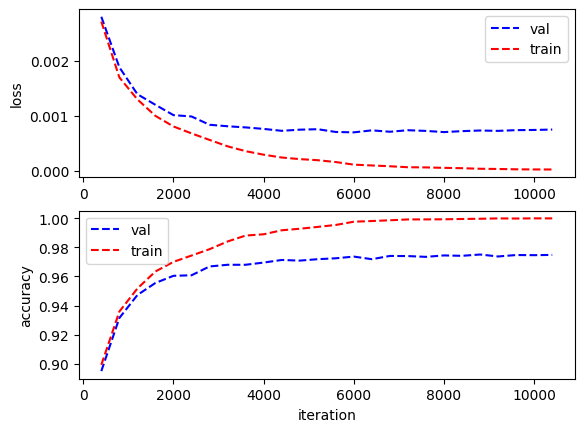

In [51]:
hp = hyperparams(ConfigEnum.MNIST)
#nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, sigmoid, sigmoid_grad)
nn = model(hp.input_size, hp.output_size, hp.hidden_shapes, relu, relu_grad)
val_hist = historian()
train_hist = historian()
logger = nnlogger(hp.output_log, ("Epoch", "Phase", "Iteration", "Accuracy", "Loss") )
train(nn, hp, val_hist, train_hist, logger)
test(nn, hp.ds_test, verbose=True, phase="Test")
nnplotter.view(val_hist, train_hist) #see results on plot
logger.close()

 # QUIZ EXTRA
 1. Resolver un problema de regresión lineal utilizando este framework
 2. Utilizar la funcion tanh en lugar de sigmoid para el entrenamiento de las capas ocultas.
 3. Resolver el problema de las variaciones del proceso de entrenamiento del gráfico.

 Domingo 6 de Octubre